# <font color= 'blue'>Forecast Sales of Drug Stores</font>

https://www.kaggle.com/c/rossmann-store-sales

In [1]:
# Import packages
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
# Load data
train_data = pd.read_csv('rossmann-store-sales/train.csv')
test_data = pd.read_csv('rossmann-store-sales/test.csv')
lojas_data = pd.read_csv('rossmann-store-sales/store.csv')
sample_submission = pd.read_csv('rossmann-store-sales/sample_submission.csv')

In [3]:
# Preview data
train_data.head().append(train_data.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [4]:
test_data.head().append(test_data.tail())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [5]:
# Preview data
lojas_data.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [6]:
# Preview data
sample_submission.head(2)

,Id,Sales
0,1,0
1,2,0


In [7]:
# Save Id column at test_data and delete Customers at train_data
id_name='Id'
test_data_id = test_data[id_name]
train_data.drop('Customers', axis = 1, inplace = True)

print("Train shape: {} ".format(train_data.shape))
print("Test shape: {} ".format(test_data.shape))

Train shape: (1017209, 8) 
Test shape: (41088, 8) 


In [8]:
def replace_cat_for_number(df):
    replace_map = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    df.StateHoliday.replace(replace_map, inplace = True)
def replace_cat(df):
    replace_map = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    df.StoreType.replace(replace_map, inplace = True)
    df.Assortment.replace(replace_map, inplace = True)
    
replace_cat_for_number(train_data)
replace_cat_for_number(test_data)
replace_cat(lojas_data)

In [9]:
# Let's add the store details to train/test datasets
train_data = pd.merge(train_data, lojas_data, how = 'left', on = 'Store') 
test_data = pd.merge(test_data, lojas_data, how = 'left', on = 'Store')

In [10]:
def check_missing(dataset, display = 5):
    temp_df = dataset.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Great! There are no missing values in this dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

In [11]:
check_missing(train_data,7)

,Missing n,% Missing
PromoInterval,508031,49.943620
Promo2SinceYear,508031,49.943620
Promo2SinceWeek,508031,49.943620
CompetitionOpenSinceYear,323348,31.787764
CompetitionOpenSinceMonth,323348,31.787764
CompetitionDistance,2642,0.259730
Assortment,0,0.000000


In [12]:
check_missing(test_data, 7)

,Missing n,% Missing
PromoInterval,17232,41.939252
Promo2SinceYear,17232,41.939252
Promo2SinceWeek,17232,41.939252
CompetitionOpenSinceYear,15216,37.032710
CompetitionOpenSinceMonth,15216,37.032710
CompetitionDistance,96,0.233645
Open,11,0.026772


In [13]:
# Registers where 'Open' is missing
test_data.loc[test_data['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
479,480,622,4,2015-09-17,NaN,1,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
1335,1336,622,3,2015-09-16,NaN,1,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
2191,2192,622,2,2015-09-15,NaN,1,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
3047,3048,622,1,2015-09-14,NaN,1,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
4759,4760,622,6,2015-09-12,NaN,0,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
5615,5616,622,5,2015-09-11,NaN,0,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
6471,6472,622,4,2015-09-10,NaN,0,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
7327,7328,622,3,2015-09-09,NaN,0,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
8183,8184,622,2,2015-09-08,NaN,0,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
9039,9040,622,1,2015-09-07,NaN,0,0,0,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN


The field Open should be 0 or 1. The missing information occurs for a particular store (622), from 05/09/2015 to 17/09/2015, with exception from 13/09/2015 (which is also a Sunday). We could check historical data for this particular store to decide on Open or Closed. However, if it's closed, then there's no Sales on that day, so we will assume they're Open, given there's no holidays and it isn't a Sunday.

In [14]:
def get_dates_info(df):
    df['Date'] = pd.to_datetime(df.Date)
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    #df['Week'] = df.Date.dt.week
    df['Day'] = df.Date.dt.day
    #df['Dayofyear'] = df.Date.dt.dayofyear
    df['WeekOfYear'] = df.Date.dt.weekofyear
    
    
get_dates_info(train_data)
get_dates_info(test_data)

In [15]:
test_data['Open'] = test_data['Open'].fillna(1)

In [16]:
# 5984 stores are closed on the test dataset. Their sales will be set to 0.
test_closed_stores_id = test_data.loc[test_data.Open == 0 , id_name]

In [17]:
closed_train = train_data.Open.value_counts()[0]
closed_test = test_data.Open.value_counts()[0]
print("Number of closed stores in train dataset: {} ".format(closed_train))
print("Number of closed stores in test dataset: {} ".format(closed_test))

Number of closed stores in train dataset: 172817 
Number of closed stores in test dataset: 5984 


As closed stores yield no Sales, we will remove the registers where the stores were closed on the training dataset

In [18]:
# Checking whether the closed stores have indeed no sales registered
train_data[(train_data['Open'] == 0) & (train_data['Sales'] == 0)]

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
291,292,5,2015-07-31,0,0,1,0,1,1,1,1100.0,6.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
875,876,5,2015-07-31,0,0,1,0,1,1,1,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov",2015,7,31,31
1406,292,4,2015-07-30,0,0,1,0,1,1,1,1100.0,6.0,2009.0,0,NaN,NaN,NaN,2015,7,30,31
1990,876,4,2015-07-30,0,0,1,0,1,1,1,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov",2015,7,30,31
2521,292,3,2015-07-29,0,0,1,0,1,1,1,1100.0,6.0,2009.0,0,NaN,NaN,NaN,2015,7,29,31
3105,876,3,2015-07-29,0,0,1,0,1,1,1,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov",2015,7,29,31
3636,292,2,2015-07-28,0,0,1,0,1,1,1,1100.0,6.0,2009.0,0,NaN,NaN,NaN,2015,7,28,31
4220,876,2,2015-07-28,0,0,1,0,1,1,1,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov",2015,7,28,31
4751,292,1,2015-07-27,0,0,1,0,1,1,1,1100.0,6.0,2009.0,0,NaN,NaN,NaN,2015,7,27,31
5335,876,1,2015-07-27,0,0,1,0,1,1,1,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov",2015,7,27,31


In [19]:
train_data = train_data[(train_data['Open'] == 1) & (train_data['Sales'] > 0)]
train_data.shape

(844338, 21)

In [20]:
test_open_stores_id = test_data.loc[test_data.Open == 1 , id_name]
test_data = test_data.loc[test_data.Open == 1 , :]

# Feature Engineering

In [21]:
def add_features(df):
    # calculate competition open time in months
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    df['PromoOpen'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4.0
    df['PromoOpen'] = df['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    # Map the month values to its correspondent string name
    month_name = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                  7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

    df['MonthName'] = df.Month.map(month_name)
    
add_features(train_data)
add_features(test_data)

In [22]:
def check(row):
    if isinstance(row['PromoInterval'],str) and row['MonthName'] in row['PromoInterval']:
        return 1
    else:
        return 0
        
train_data['IsPromoMonth'] =  train_data.apply(lambda row: check(row),axis = 1) 
test_data['IsPromoMonth'] =  test_data.apply(lambda row: check(row),axis = 1) 

In [23]:
promo_rng = list((train_data['PromoInterval'].append(test_data['PromoInterval'])).unique())

In [24]:
# PromoInterval
train_data['PromoInterval'] = [promo_rng.index(x) for x in train_data['PromoInterval']]
test_data['PromoInterval'] = [promo_rng.index(x) for x in test_data['PromoInterval']]

train_data['CompetitionDistance'].fillna(train_data['CompetitionDistance'].median(), inplace = True)
test_data['CompetitionDistance'].fillna(train_data['CompetitionDistance'].median(), inplace = True)

# Drop the following items as they're no longer useful -- created CompetitionOpen and PromoOpen out of them
droplist = ['Promo2SinceYear', 'Promo2SinceWeek','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
           'WeekOfYear','Promo2']

for df in [train_data, test_data]:
    df.drop( droplist, axis = 1, inplace = True)

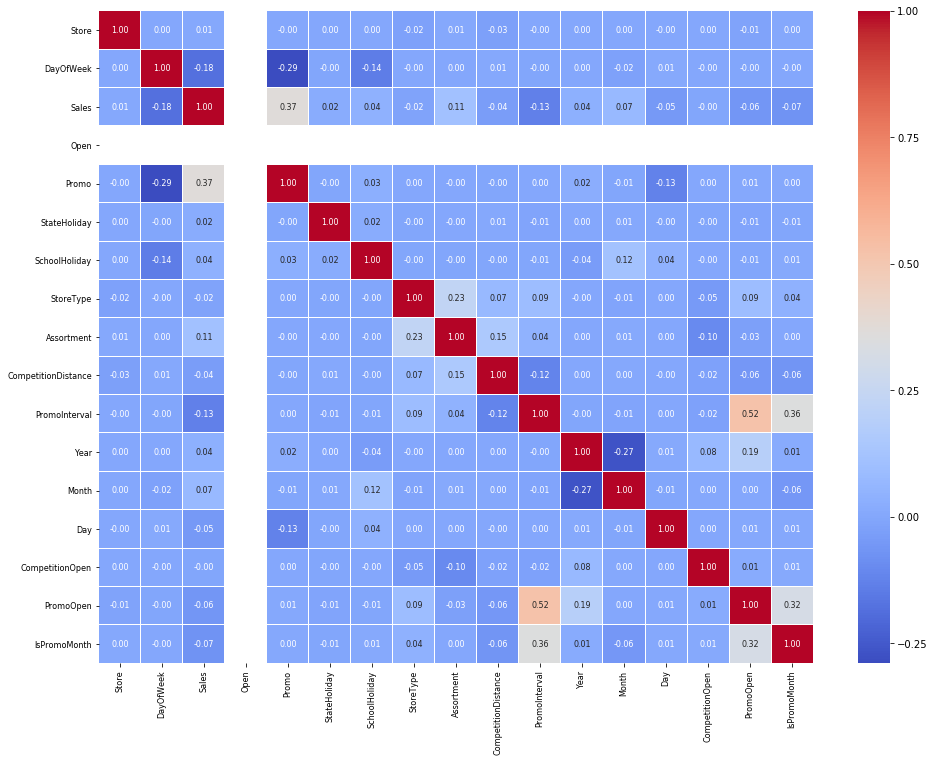

In [25]:
# Calculates the correlation and plot the data in a heatmap
sns.heatmap(train_data.corr(), annot = True, cmap = 'coolwarm', linewidths = 0.01, annot_kws = {'size':8}, fmt = '.2f')
fig = plt.gcf()
fig.set_size_inches(16,12)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

In [26]:
train_data['Id'] = -1
test_data['Sales'] = -1
train_data.shape
test_data.shape
full_data = pd.concat([train_data,test_data])

In [27]:
dummies = ['StateHoliday', 'StoreType', 'Assortment']
full_data = pd.get_dummies(data = full_data, columns = dummies)

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_col = ['Day','Month','PromoInterval','Store','Year']
for col in cat_col:
    full_data[col] = le.fit_transform(full_data[col])

In [29]:
droplist = ['MonthName','Date']

full_data.drop( droplist, axis = 1, inplace = True)

train_data = full_data.loc[full_data['Id'] == -1, :]
test_data = full_data.loc[full_data['Sales'] == -1, :]

In [30]:
from sklearn.preprocessing import StandardScaler,Normalizer,FunctionTransformer,QuantileTransformer,PowerTransformer
        
select = ['CompetitionDistance','CompetitionOpen','PromoOpen']
    
scaler_x = StandardScaler()
normal_x = Normalizer()

scaler_y = StandardScaler()

for df in [train_data, test_data]:
    df_scaled = pd.DataFrame(scaler_x.fit_transform(df[select]))
    df_transformed = pd.DataFrame(normal_x.fit_transform(df_scaled))
    df_transformed.columns = select
    df[select] = df_transformed

In [31]:
df_train = train_data
df_test = test_data

In [32]:
from sklearn.model_selection import train_test_split

X = df_train
y = df_train['Sales']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [33]:
features = [c for c in df_train.columns if c not in ['Id','Sales','Open']]

In [34]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [35]:
from sklearn.metrics import make_scorer

def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean( ((y - yhat)/y)**2 ))
    return rmspe

def rmspe_xg(y, yhat):
    yhat = yhat.get_label()
    yhat = np.exp(yhat) - 1
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return "rmspe", rmspe

In [36]:
import xgboost as xgb

params = {"objective": "reg:linear",
          "n_estimators": 1500 , 
          "learning_rate": 0.2  ,
          "eta": 0.1,
          "max_depth": 10,
          "min_child_weight": 5 ,
          "subsample": 0.8,
          "gamma": 0.3,
          "colsample_bytree": 0.9,
          "silent": 0
          }
num_trees = 500

print("Training...")

dtrain = xgb.DMatrix(X_train[features], np.log1p(X_train['Sales']))
dvalid = xgb.DMatrix(X_test[features], np.log1p(X_test['Sales']))
dtest = xgb.DMatrix(df_test[features])

watchlist = [ (dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_trees, evals = watchlist, 
                early_stopping_rounds = 50, feval=rmspe_xg, verbose_eval=True)

Training...
[13:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:6.61831	eval-rmse:6.62035	train-rmspe:3505.23	eval-rmspe:3515.65
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:5.29895	eval-rmse:5.30119	train-rmspe:2168.06	eval-rmspe:2174.53
[2]	train-rmse:4.24432	eval-rmse:4.24668	train-rmspe:1660.61	eval-rmspe:1665.55
[3]	train-rmse:3.40184	eval-rmse:3.40434	train-rmspe:1398.93	eval-rmspe:1403.14
[4]	train-rmse:2.72914	eval-rmse:2.73167	train-rmspe:1241.97	eval-rmspe:1245.7
[5]	train-rmse:2.19228	eval-rmse:2.19481	train-rmspe:1139.21	eval-rmspe:1142.63
[6]	train-rmse:1.7645	eval-rmse:1.76705	train-rmspe:1068.46	eval-rmspe:1071.67
[7]	train-rmse:1.42475	eval-rmse:1.42725	train-rmspe:1017.91	eval-rmspe:1020.97
[8]	train-rmse:1.15502	eval-rmse:1.15738	train-rmspe:980.495	eval-rmspe:983.40

[97]	train-rmse:0.146363	eval-rmse:0.149978	train-rmspe:842.7	eval-rmspe:845.037
[98]	train-rmse:0.145046	eval-rmse:0.148641	train-rmspe:842.569	eval-rmspe:844.901
[99]	train-rmse:0.144504	eval-rmse:0.148122	train-rmspe:842.534	eval-rmspe:844.867
[100]	train-rmse:0.143632	eval-rmse:0.147214	train-rmspe:842.462	eval-rmspe:844.793
[101]	train-rmse:0.142702	eval-rmse:0.146273	train-rmspe:842.397	eval-rmspe:844.726
[102]	train-rmse:0.141604	eval-rmse:0.14515	train-rmspe:842.341	eval-rmspe:844.666
[103]	train-rmse:0.140269	eval-rmse:0.143881	train-rmspe:842.25	eval-rmspe:844.574
[104]	train-rmse:0.139251	eval-rmse:0.142872	train-rmspe:842.173	eval-rmspe:844.496
[105]	train-rmse:0.138574	eval-rmse:0.142207	train-rmspe:842.092	eval-rmspe:844.411
[106]	train-rmse:0.137809	eval-rmse:0.141491	train-rmspe:842.05	eval-rmspe:844.372
[107]	train-rmse:0.137627	eval-rmse:0.141324	train-rmspe:842.035	eval-rmspe:844.358
[108]	train-rmse:0.137367	eval-rmse:0.141065	train-rmspe:842.016	eval-rmspe:844.339


[195]	train-rmse:0.112974	eval-rmse:0.117291	train-rmspe:839.95	eval-rmspe:842.26
[196]	train-rmse:0.112783	eval-rmse:0.117107	train-rmspe:839.929	eval-rmspe:842.24
[197]	train-rmse:0.112678	eval-rmse:0.116999	train-rmspe:839.911	eval-rmspe:842.222
[198]	train-rmse:0.11267	eval-rmse:0.116991	train-rmspe:839.909	eval-rmspe:842.22
[199]	train-rmse:0.112539	eval-rmse:0.116859	train-rmspe:839.889	eval-rmspe:842.201
[200]	train-rmse:0.112376	eval-rmse:0.116713	train-rmspe:839.878	eval-rmspe:842.189
[201]	train-rmse:0.112376	eval-rmse:0.116713	train-rmspe:839.877	eval-rmspe:842.188
[202]	train-rmse:0.112086	eval-rmse:0.116426	train-rmspe:839.857	eval-rmspe:842.168
[203]	train-rmse:0.111755	eval-rmse:0.1161	train-rmspe:839.838	eval-rmspe:842.149
[204]	train-rmse:0.111612	eval-rmse:0.115957	train-rmspe:839.816	eval-rmspe:842.125
[205]	train-rmse:0.111596	eval-rmse:0.115945	train-rmspe:839.812	eval-rmspe:842.121
[206]	train-rmse:0.111547	eval-rmse:0.115899	train-rmspe:839.808	eval-rmspe:842.117

[293]	train-rmse:0.107198	eval-rmse:0.111973	train-rmspe:839.401	eval-rmspe:841.715
[294]	train-rmse:0.107193	eval-rmse:0.111972	train-rmspe:839.402	eval-rmspe:841.715
[295]	train-rmse:0.107191	eval-rmse:0.111971	train-rmspe:839.402	eval-rmspe:841.715
[296]	train-rmse:0.107188	eval-rmse:0.111971	train-rmspe:839.401	eval-rmspe:841.715
[297]	train-rmse:0.107186	eval-rmse:0.111971	train-rmspe:839.399	eval-rmspe:841.712
[298]	train-rmse:0.107171	eval-rmse:0.111962	train-rmspe:839.397	eval-rmspe:841.71
[299]	train-rmse:0.107171	eval-rmse:0.111962	train-rmspe:839.397	eval-rmspe:841.711
[300]	train-rmse:0.107033	eval-rmse:0.111841	train-rmspe:839.376	eval-rmspe:841.69
[301]	train-rmse:0.10703	eval-rmse:0.111841	train-rmspe:839.376	eval-rmspe:841.69
[302]	train-rmse:0.107026	eval-rmse:0.111841	train-rmspe:839.377	eval-rmspe:841.69
[303]	train-rmse:0.107016	eval-rmse:0.111831	train-rmspe:839.373	eval-rmspe:841.687
[304]	train-rmse:0.106988	eval-rmse:0.111811	train-rmspe:839.372	eval-rmspe:841.6

[392]	train-rmse:0.104858	eval-rmse:0.109847	train-rmspe:839.183	eval-rmspe:841.495
[393]	train-rmse:0.104759	eval-rmse:0.109752	train-rmspe:839.171	eval-rmspe:841.484
[394]	train-rmse:0.104753	eval-rmse:0.109747	train-rmspe:839.169	eval-rmspe:841.482
[395]	train-rmse:0.104742	eval-rmse:0.109737	train-rmspe:839.169	eval-rmspe:841.482
[396]	train-rmse:0.104735	eval-rmse:0.109733	train-rmspe:839.169	eval-rmspe:841.482
[397]	train-rmse:0.104735	eval-rmse:0.109733	train-rmspe:839.168	eval-rmspe:841.481
[398]	train-rmse:0.104711	eval-rmse:0.109707	train-rmspe:839.166	eval-rmspe:841.479
[399]	train-rmse:0.104687	eval-rmse:0.109677	train-rmspe:839.165	eval-rmspe:841.478
[400]	train-rmse:0.104685	eval-rmse:0.109678	train-rmspe:839.165	eval-rmspe:841.478
[401]	train-rmse:0.104669	eval-rmse:0.109667	train-rmspe:839.163	eval-rmspe:841.477
[402]	train-rmse:0.104666	eval-rmse:0.109668	train-rmspe:839.162	eval-rmspe:841.476
[403]	train-rmse:0.104625	eval-rmse:0.109632	train-rmspe:839.158	eval-rmspe:

[491]	train-rmse:0.10346	eval-rmse:0.108579	train-rmspe:839.052	eval-rmspe:841.367
[492]	train-rmse:0.10346	eval-rmse:0.108579	train-rmspe:839.053	eval-rmspe:841.368
[493]	train-rmse:0.103415	eval-rmse:0.10854	train-rmspe:839.052	eval-rmspe:841.365
[494]	train-rmse:0.103401	eval-rmse:0.108528	train-rmspe:839.048	eval-rmspe:841.361
[495]	train-rmse:0.103389	eval-rmse:0.10852	train-rmspe:839.047	eval-rmspe:841.361
[496]	train-rmse:0.103387	eval-rmse:0.108519	train-rmspe:839.048	eval-rmspe:841.362
[497]	train-rmse:0.103387	eval-rmse:0.108519	train-rmspe:839.049	eval-rmspe:841.362
[498]	train-rmse:0.103387	eval-rmse:0.108519	train-rmspe:839.048	eval-rmspe:841.362
[499]	train-rmse:0.103382	eval-rmse:0.108514	train-rmspe:839.049	eval-rmspe:841.363


In [37]:
print("Validating...")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe( X_test.Sales.values,np.expm1(train_probs))
print('error: {0:0.4f}'.format(error))

Validating
error: 0.1261


In [38]:
print("Make predictions on the submission set")
output = gbm.predict(xgb.DMatrix(df_test[features]))
output[output < 0] = 0

Make predictions on the submission set


In [39]:
submission_part1 = pd.DataFrame({"Id": test_closed_stores_id, "Sales": 0})
submission_part2 = pd.DataFrame({"Id": test_open_stores_id, "Sales": np.expm1(output)})
submission = pd.concat([submission_part1, submission_part2], axis = 0)
submission.to_csv("submission_xgboost.csv", index = False)